In [3]:
import numpy as np
import mrcfile
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import tensorflow as tf
from tensorflow import spectral
from ClassFiles.relion_fixed_it import load_star
from ClassFiles.AdversarialRegularizer import AdversarialRegulariser
from ClassFiles.ut import l2
from ClassFiles.Utilities import registration
from ClassFiles.ut import locate_gt, rfft, irfft, unify_form, Rescaler

In [4]:
# saves_path = '/local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/AllData/AllAugmentation'
saves_path = '/local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/Cutoff_20/Translation_Augmentation'
regularizer = AdversarialRegulariser(saves_path)

INFO:tensorflow:Restoring parameters from /local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/Cutoff_20/Translation_Augmentation/Data/model-20000
Save restored


In [5]:
Registrator = registration.LocalRegistrator()

/alt/applic/user-maint/sl767/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [10]:
def l2_gt(x):
    image=unify_form(np.copy(x))
    r=Rescaler(image)
    r.normalize(image)
    reg=Registrator.register(image=image, reference=ground_truth)
    return l2(reg-ground_truth)

In [11]:
def vis(data, fourier=True):
    if fourier:
        data = irfft(data)
    plt.imshow(data.squeeze()[...,45])
#     plt.imshow(np.mean(data.squeeze(), axis=-1))

In [53]:
NOISE_LEVEL = '01'
ITERATION = '10'
METHODE = 'EM'
PDB_ID = '5A0M'

In [54]:
base_path = '/local/scratch/public/sl767/MRC_Data/Data/Data_0{n}_10k/eval/{m}/{PDB}/'
path=base_path+'{PDB}_mult0{n}_it0{i}_half2_class001_external_reconstruct.star'
path = path.format(n=NOISE_LEVEL, m=METHODE, PDB = PDB_ID, i=ITERATION)

In [55]:
file=load_star(path)

In [56]:
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataReal']) as mrc:
    data_real = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataImag']) as mrc:
    data_im = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsWeight']) as mrc:
    kernel = mrc.data.copy()
with mrcfile.open(locate_gt(PDB_ID, full_path=False)) as mrc:
    ground_truth = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsResult']) as mrc:
    naive_recon = mrc.data.copy()
    
ground_truth = unify_form(ground_truth)
r_gt = Rescaler(ground_truth)
r_gt.normalize(ground_truth)

complex_data=data_real + 1j * data_im

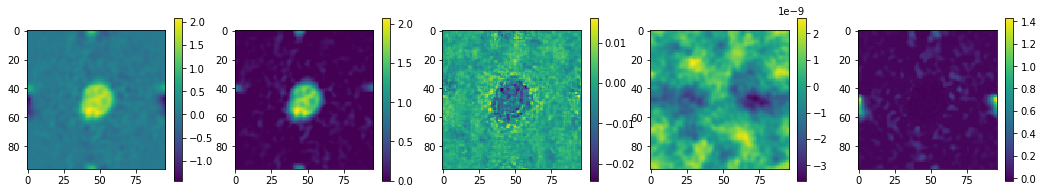

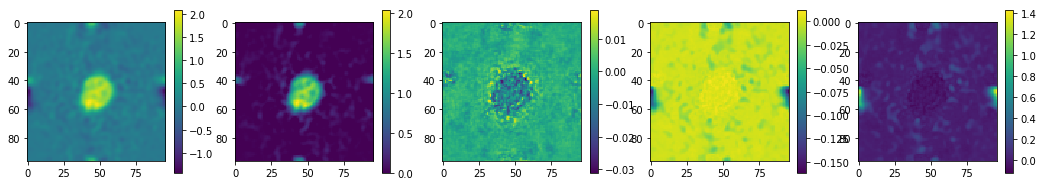

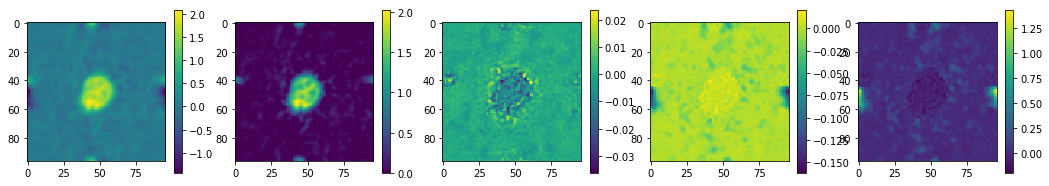

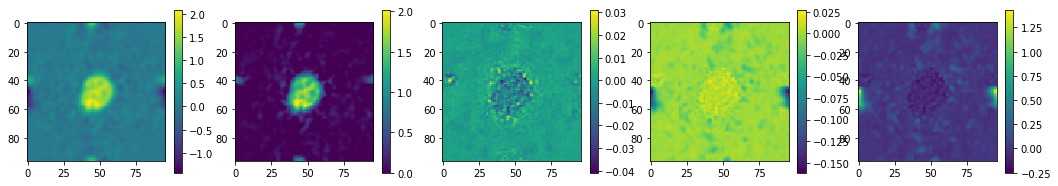

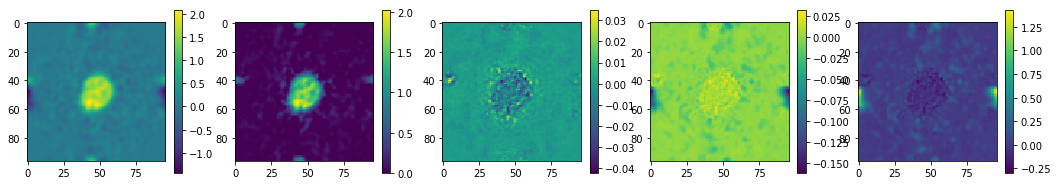

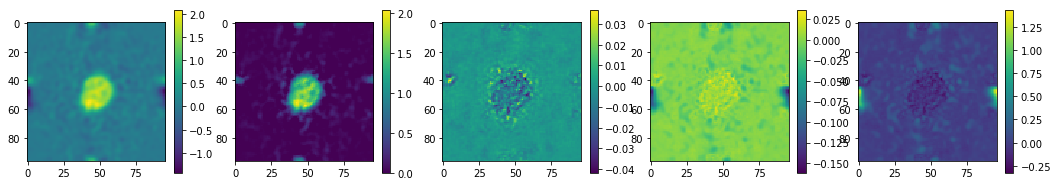

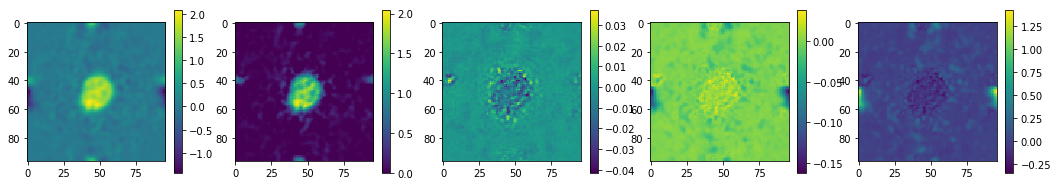

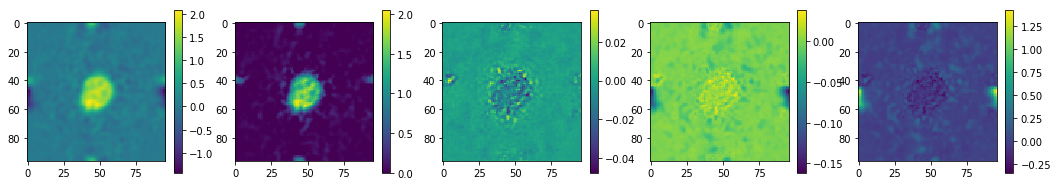

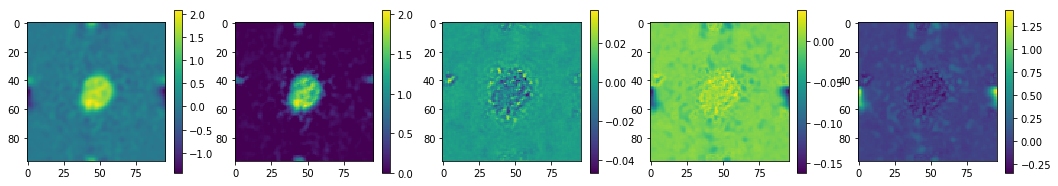

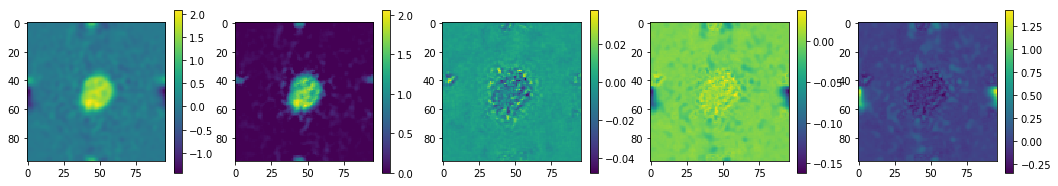

In [57]:
REG = 0.0075
    
tikhonov_kernel = kernel + 1e6
precondioner = np.abs(np.divide(1, tikhonov_kernel))
precondioner /= precondioner.max()
tikhonov = np.divide(complex_data, tikhonov_kernel)
reco = np.copy(tikhonov)

# The scales produce gradients of order 1
ADVERSARIAL_SCALE=(96**(-0.5))
DATA_SCALE=1/(10*96**3)

IMAGING_SCALE=96

for k in range(50):
    STEP_SIZE=1.0 * 1 / np.sqrt(1 + k / 20)
    
    gradient = regularizer.evaluate(reco)
    g1 = REG * gradient * ADVERSARIAL_SCALE
#     print(l2(gradient))
    g2 = DATA_SCALE*(np.multiply(reco, tikhonov_kernel) - complex_data)
    
    g = g1 + g2
#     reco = reco - STEP_SIZE * 0.02 * g
    reco = reco - STEP_SIZE * precondioner * g
    
    reco = np.fft.rfftn(np.maximum(0, np.fft.irfftn(reco)))
        
    #reco = reco - STEP_SIZE*(g1 + g2 + g3)
    if k%5==0:
        plt.figure(k, figsize=(18,3))
        plt.subplot(151)
        vis(IMAGING_SCALE*tikhonov)
        plt.colorbar()
        plt.subplot(152)
        vis(IMAGING_SCALE*reco)
        plt.colorbar()
        plt.subplot(153)
        vis(-IMAGING_SCALE*precondioner*g1)
        plt.colorbar()
        plt.subplot(154)
        vis(-IMAGING_SCALE*precondioner*g2)
        plt.colorbar()
        plt.subplot(155)
        vis(IMAGING_SCALE*(reco - tikhonov))
        plt.colorbar()
        plt.show()

In [22]:
def evaluate(reg):
    tikhonov_kernel = kernel + 1e6
    precondioner = np.abs(np.divide(1, tikhonov_kernel))
    precondioner /= precondioner.max()
    tikhonov = np.divide(complex_data, tikhonov_kernel)
    reco = np.copy(tikhonov)

    # The scales produce gradients of order 1
    ADVERSARIAL_SCALE=(96**(-0.5))
    DATA_SCALE=1/(10*96**3)

    IMAGING_SCALE=96

    for k in range(70):
        STEP_SIZE=1.0 * 1 / np.sqrt(1 + k / 20)

        gradient = regularizer.evaluate(reco)
        g1 = reg * gradient * ADVERSARIAL_SCALE
    #     print(l2(gradient))
        g2 = DATA_SCALE*(np.multiply(reco, tikhonov_kernel) - complex_data)

        g = g1 + g2
    #     reco = reco - STEP_SIZE * 0.02 * g
        reco = reco - STEP_SIZE * precondioner * g

        reco = np.fft.rfftn(np.maximum(0, np.fft.irfftn(reco)))
    return l2_gt(irfft(reco))

In [50]:
parameters = [0.0, 0.005, 0.0075, 0.01]
results = {}
for reg in parameters:
    results['Reg_{}'.format(reg)] = evaluate(reg = reg)

0.923596
0.913394
0.917093
0.914906
0.912669
Final Registration Loss: 0.912029
Rotation: 
[[[ 0.99983025  0.0026887   0.01822694]
  [-0.00261877  0.9999891  -0.00385941]
  [-0.01823712  0.00381102  0.99982643]]]
Translation: 
[[[ 0.00104791]
  [ 0.00969748]
  [ 0.00306977]]]
0.920466
0.912722
0.911236
0.911996
0.908391
Final Registration Loss: 0.907418
Rotation: 
[[[  9.99744236e-01  -6.82394719e-03   2.15633828e-02]
  [  6.81137666e-03   9.99976575e-01   6.56335556e-04]
  [ -2.15673558e-02  -5.09291305e-04   9.99767303e-01]]]
Translation: 
[[[ 0.00055586]
  [ 0.00903769]
  [-0.00013371]]]
0.92424
0.912997
0.910512
0.910995
0.908129
Final Registration Loss: 0.907282
Rotation: 
[[[ 0.999707    0.00773664  0.02293731]
  [-0.00766425  0.9999654  -0.00324215]
  [-0.0229616   0.0030654   0.99973166]]]
Translation: 
[[[ 0.00183135]
  [ 0.00819124]
  [ 0.00380242]]]
0.935301
0.914497
0.916572
0.909206
0.908399
Final Registration Loss: 0.908385
Rotation: 
[[[ 0.99984205  0.00617183  0.0166638 

In [58]:
print(results)

{'Reg_0.0': 0.92693233, 'Reg_0.005': 0.92485529, 'Reg_0.0075': 0.92504144, 'Reg_0.01': 0.9259944}


# Optimal parameters:

- SNR .02, first iterate: .03 --> Improvement .015
- SNR .02, 10th iterate: .05 --> Improvement .08
- SNR .01, first iterate: .005 (reasonable till .01) --> Improvement .002
- SNR .01, 10th: .005 (reasonable till .01) --> Improvement .002

In [15]:
for l, item in res1.items():
    print(l)
    print(item)

Reg_0.0
0.926861
Reg_0.001
0.926727
Reg_0.002
0.926671
Reg_0.005
0.926822
Reg_0.01
0.928034


# Results for 10th iterate, SNR .01

In [25]:
for l, item in results.items():
    print(l)
    print(item)

Reg_0.0
0.96947
Reg_0.001
0.968683
Reg_0.002
0.968957
Reg_0.005
0.968748
Reg_0.01
0.968847
Reg_0.02
0.972109
Reg_0.05
1.00863


# Results for 01st iterate, SNR .02

In [32]:
for l, item in results.items():
    print(l)
    print(item)

Reg_0.0
0.786947
Reg_0.001
0.78646
Reg_0.002
0.785675
Reg_0.005
0.784036
Reg_0.01
0.782251
Reg_0.02
0.78097
Reg_0.05
0.793211


# Results for 10th iterate, SNR .02

In [42]:
for l, item in results.items():
    print(l)
    print(item)

Reg_0.0
0.629159
Reg_0.001
0.62979
Reg_0.002
0.626202
Reg_0.005
0.624027
Reg_0.01
0.618987
Reg_0.02
0.610808
Reg_0.05
0.60086
